# High Value Customer Identification

# Planejamento da Solução

## Input - Entrada

### Problema de Negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )


## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras ) 
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra
        #
        - Custo:
            - Baixo número de devoluções
        #
        - Experiência:  
            - Média alta de avaliações

#
2. Quantos clientes farão parte do grupo?

    - Número de clientes
    - % em relação ao total de clientes

#
3. Quais as principais características desses clientes?
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
    #
    - Escrever os principais comportamentos de compra dos clientes ( métricas de negócio )
        - Vide acima

#
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.

#
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )

#
6. Quais as condições para uma pessoa ser elegível ao Insiders ?

    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders.

#
7. Quais as condições para uma pessoa ser removida do Insiders ?

    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders.

#
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

    - Teste de Hipóteses
    - Teste A/B

#
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [2]:
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec
from plotly import express as px

import umap.umap_ as umap

from sklearn import metrics as m
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [3]:
def notebook_settings():
    '''Define configurations for notebook, matplotlib and Pandas.'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignore future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()

In [4]:
notebook_settings()

## 0.2 Load Data

In [5]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', low_memory=False, encoding='cp1252')

# 1.0 Descrição dos dados

In [6]:
df1 = data_raw.copy()

df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN


## 1.1 Rename Columns

In [7]:
# Drop error column
df1 = df1.drop(columns=['Unnamed: 8'], axis=1)

cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
              'unit_price', 'customer_id', 'country']

df1.columns = cols_news

## 1.2 Data Dimension

In [8]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 541909
number of cols: 8


## 1.3 Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fillout NA

In [11]:
df1.dropna(subset=['description', 'customer_id'], inplace=True)
print(f'impact of drop: {1 - df1.shape[0] / data_raw.shape[0]:.3f}')

impact of drop: 0.249


In [12]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change Types

In [13]:
# change invoice_date into date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# change customer_id into int 
df1['customer_id'] = df1['customer_id'].astype('int64')

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes

### 1.7.2 Categorical Attributes

# 2.0 Feature Engineering

In [28]:
df2 = df1.copy()

## 2.1 MindMap Hypothesis

## 2.2 Lista final de hipóteses

## 2.3 Feature Engineering

In [29]:
# -------------------- Features based on RFM Model ---------------
# make data frame for reference
df_ref = df2[['customer_id']].drop_duplicates(ignore_index=True)


# Gross Revenue (Faturamento) | quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']


# Monetary - Total buys from each customer
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


# Recency - Last day purchase for each customer
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace=True)
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# Frequency - total number of purchases
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# Avg ticket - average purchases per customer
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index()
df_avg_ticket.columns = ['customer_id', 'avg_ticket']
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

# 3.0 Filtragem de variáveis

In [30]:
df3 = df_ref.copy()

## 3.1 Filtragem das linhas

## 3.2 Seleção das colunas

# 4.0 Análise exploratória dos dados

## 4.1 Análise Univariada

In [31]:
df4 = df3.copy()

### 4.1.1 Response Variable

### 4.1.2 Numerical Variable

### 4.1.3 Categorical Variable

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais na media.

**VERDADEIRA** Lojas com MAIOR SORTIMENTO vendem em média MAIS

### 4.2.1 Resumo das Hipóteses

## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

### 4.3.2 Atributos categóricos

# 5.0 Preparação dos dados

In [32]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

## 5.3 Transformação

### 5.3.1 Encoding

### 5.3.2 Response Variable Transformation

### 5.3.3 Nature Transformation

# 6.0 Feature Selection

In [33]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test dataset

## 6.2 Boruta as feature selector

## 6.3 Manual Feature Selection

# 7.0 Hyper Parameter Fine Tunning

In [37]:
# drop customer id for ML train
X = df6.drop(columns=['customer_id'])
X

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.630,302,35,16.951
1,3079.100,31,18,15.710
2,7187.340,2,18,28.635
3,948.250,95,5,33.866
4,635.100,330,6,105.850
...,...,...,...,...
4367,196.890,1,1,16.407
4368,343.500,1,1,19.083
4369,360.000,1,1,180.000
4370,227.390,1,1,18.949


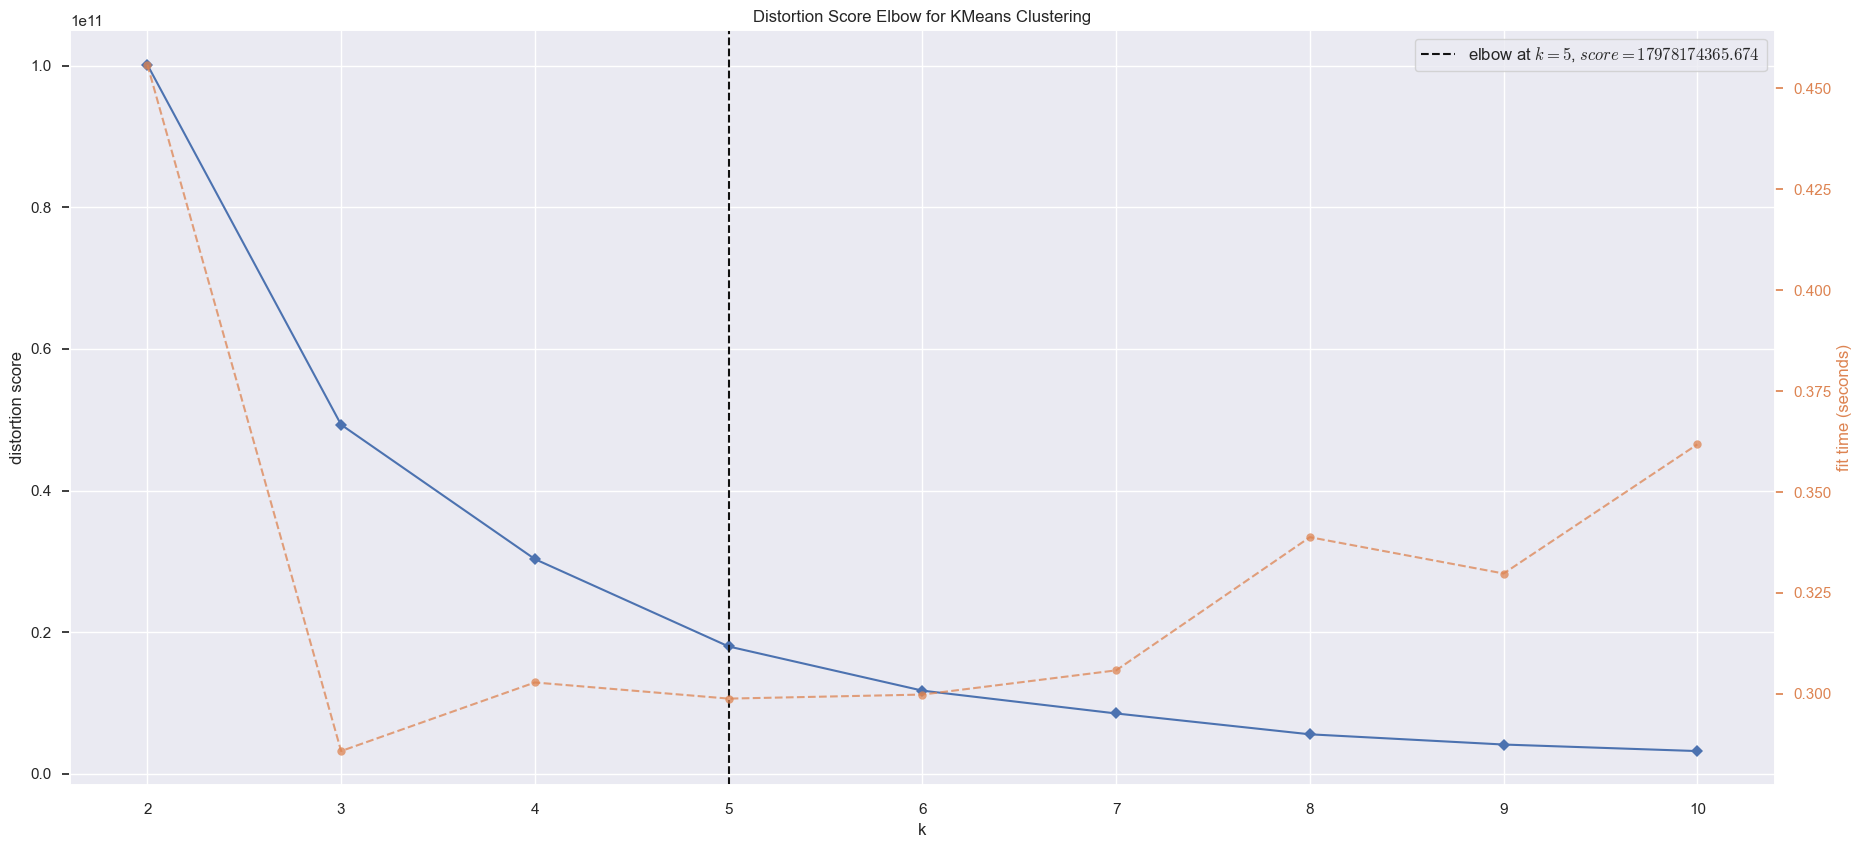

In [36]:
# make search space for clusters
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Analysis metric - WSS (Within-Cluster Sum of Squares)
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=True)
kmeans.fit(X)
kmeans.show();

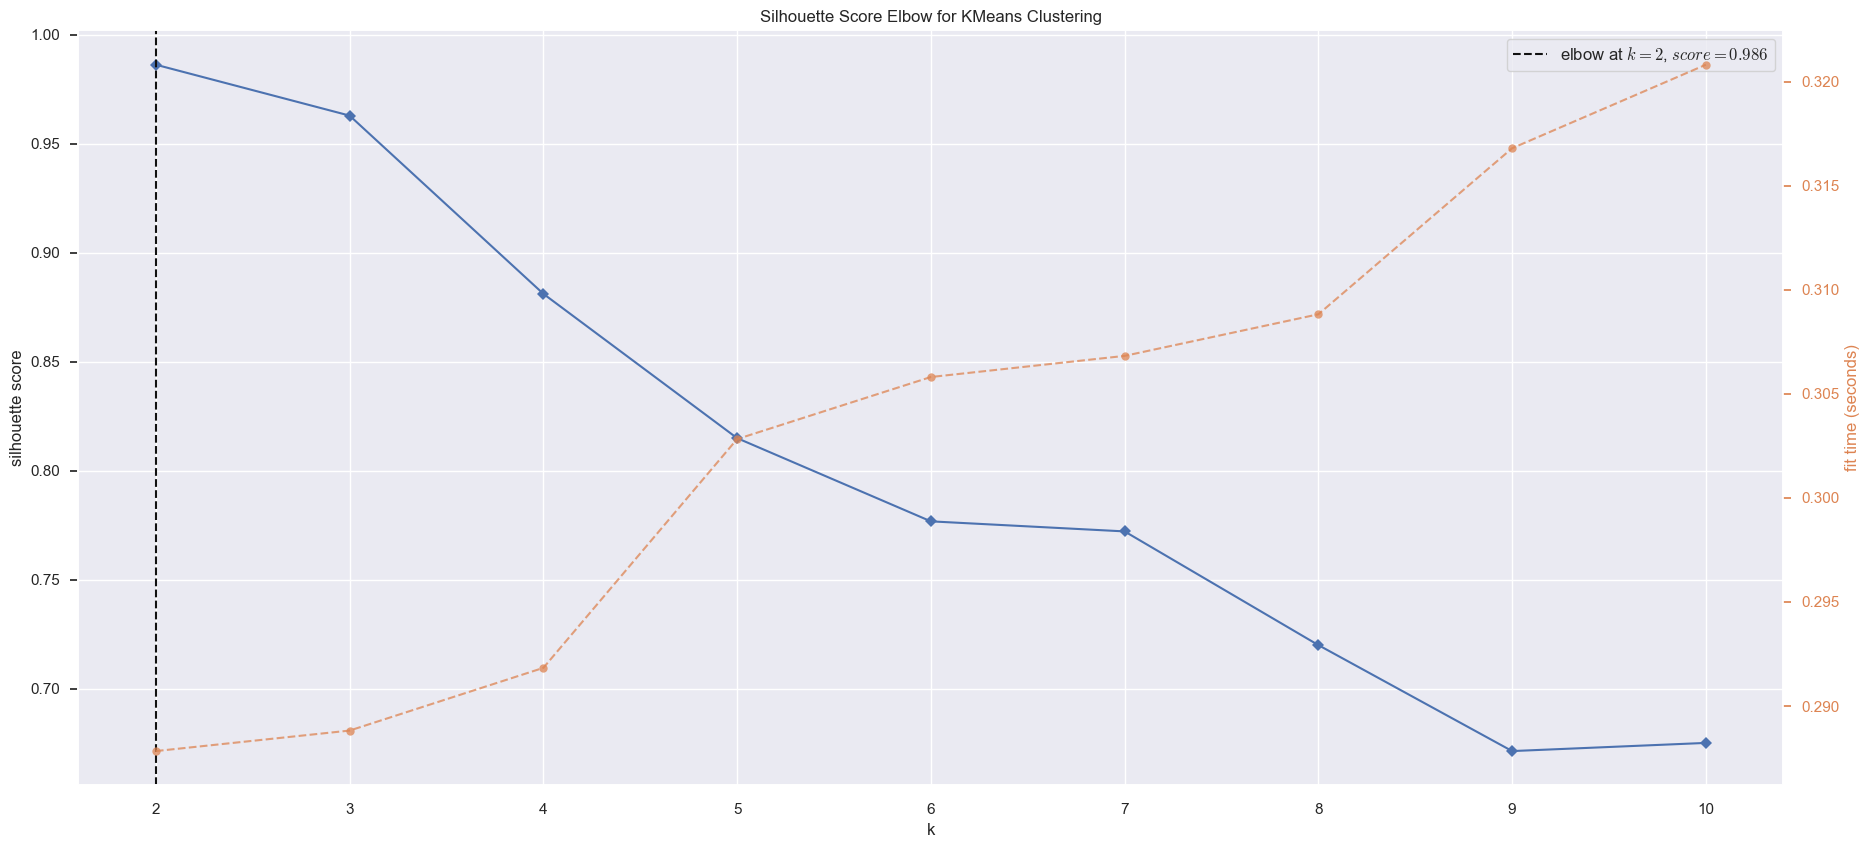

In [38]:
# Analysis metric - SS (Silhouette score)
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=True)
kmeans.fit(X)
kmeans.show();

## 7.1 Silhouette Analysis

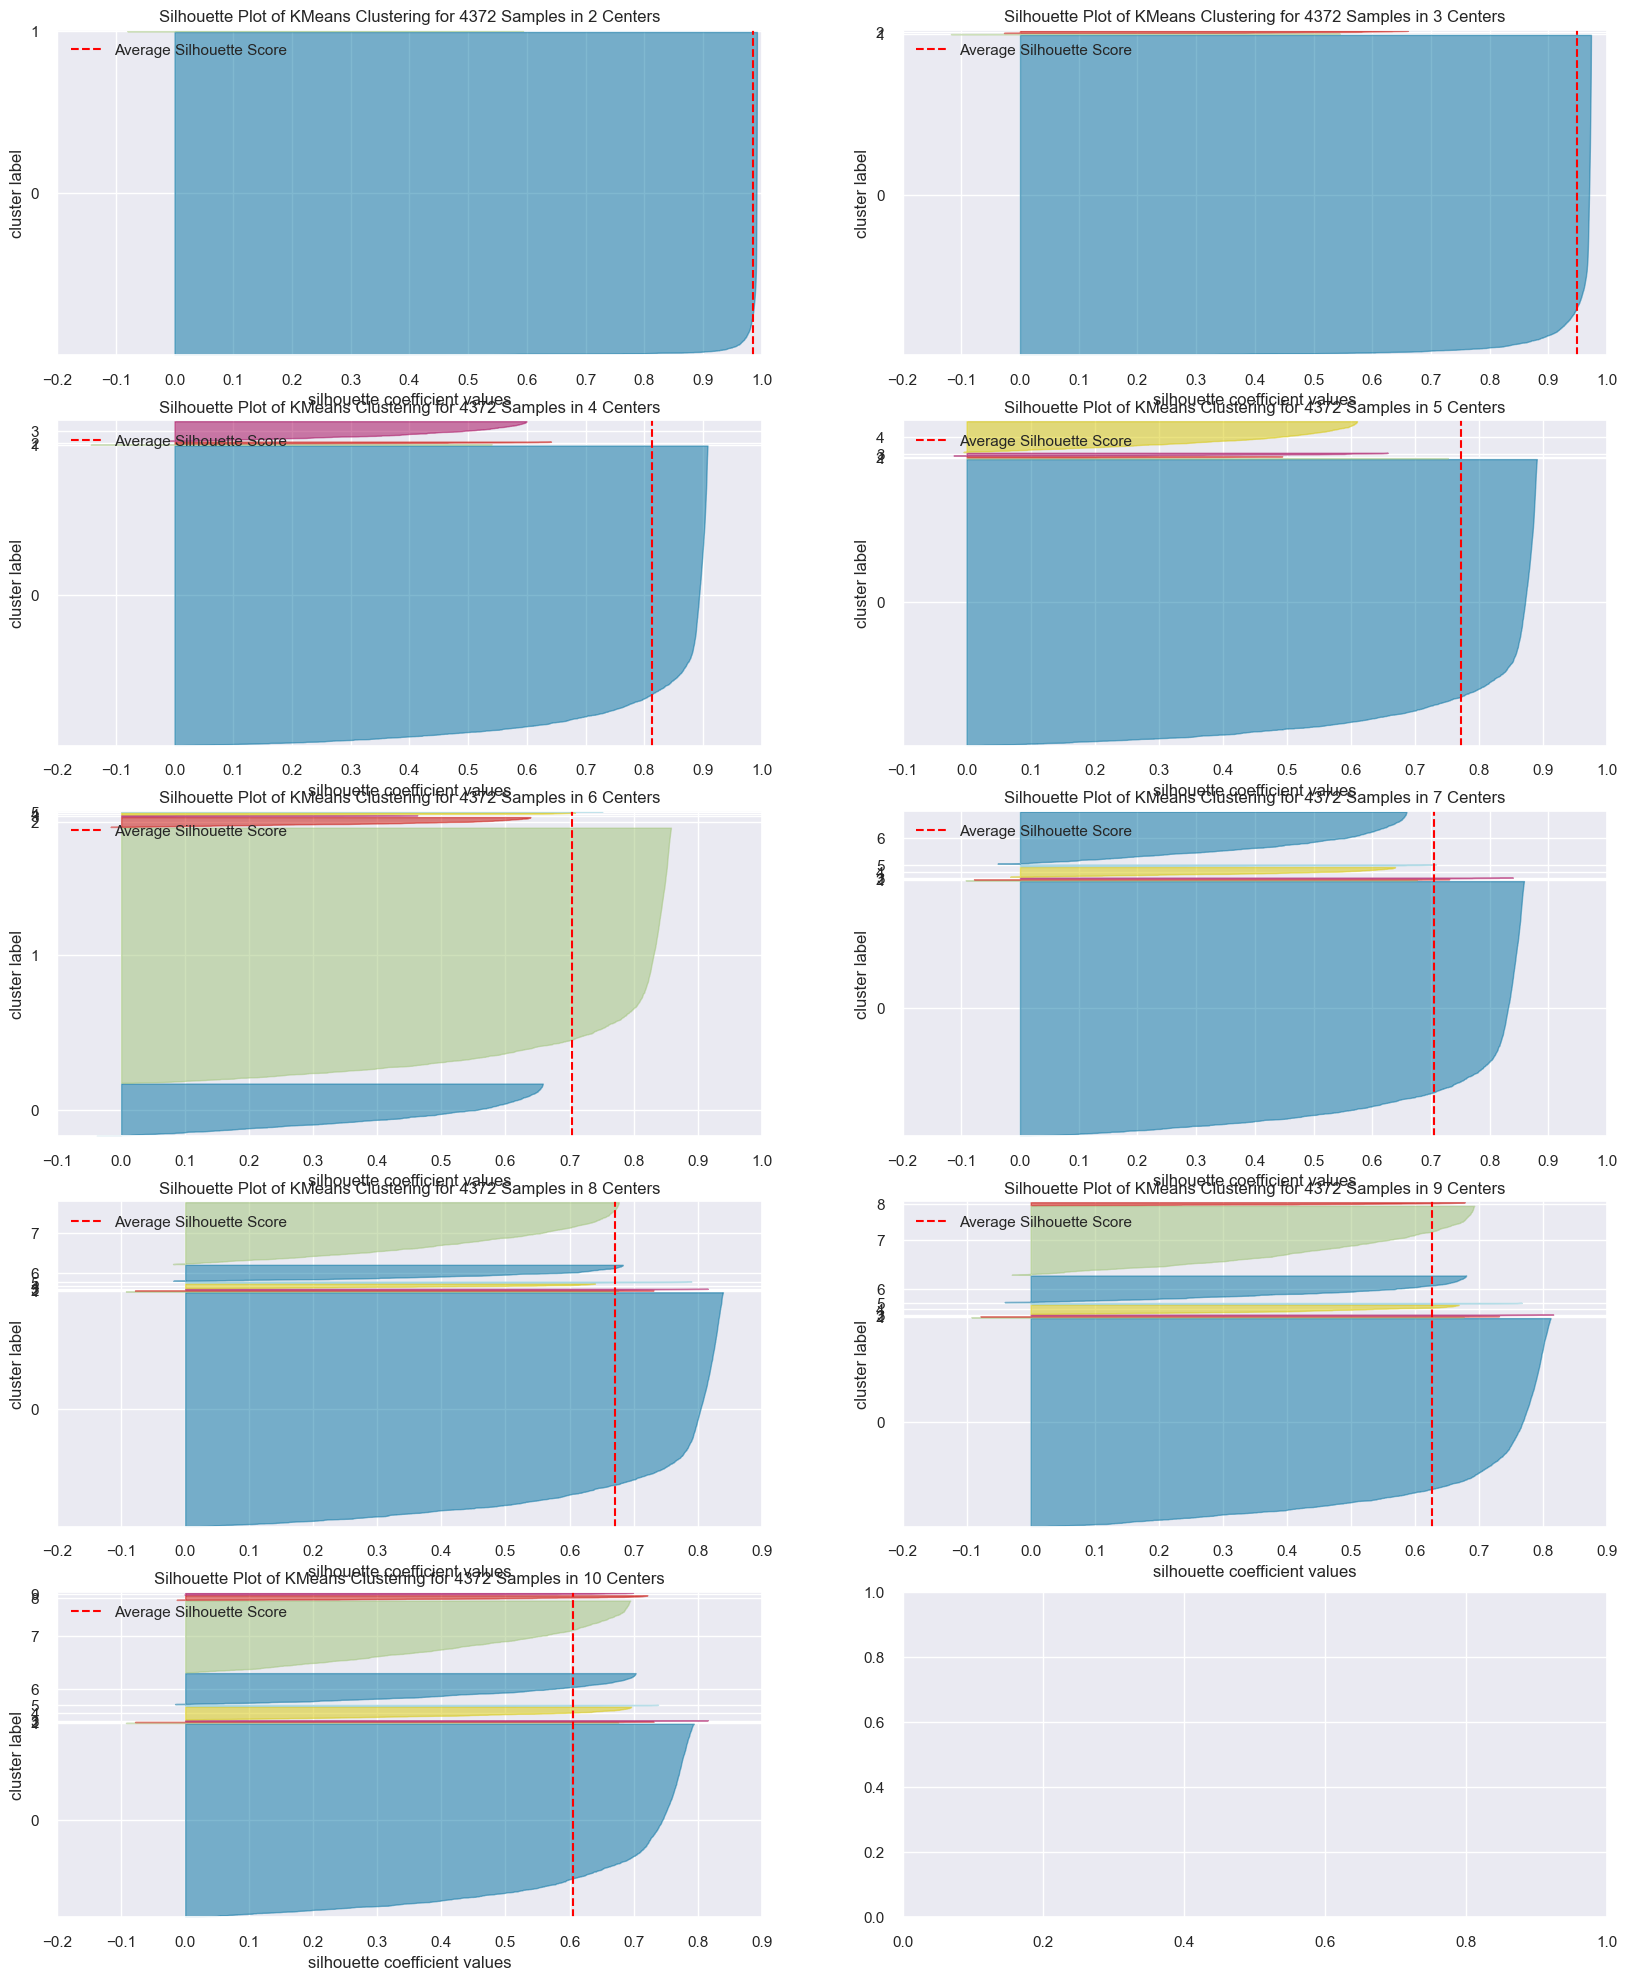

In [41]:
fig, ax = plt.subplots(5, 2, figsize=(20,25))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0 Machine Learning Modeling

## 8.1 K-Means

In [42]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [43]:
# WSS (Within_cluster sum of square)
print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
SS = m.silhouette_score(X, labels)
print(f'SS Value: {SS}')

WSS Value: 52900059994.70387
SS Value: 0.9492955993916989


## 8.6 Compare Model's Performance

### 8.6.2 Real Performance - Cross Validation

# 9.0 Cluster Analysis

In [44]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.630,302,35,16.951,0
1,13047,3079.100,31,18,15.710,0
2,12583,7187.340,2,18,28.635,0
3,13748,948.250,95,5,33.866,0
4,15100,635.100,330,6,105.850,0


## 9.1 Visualization Inspection

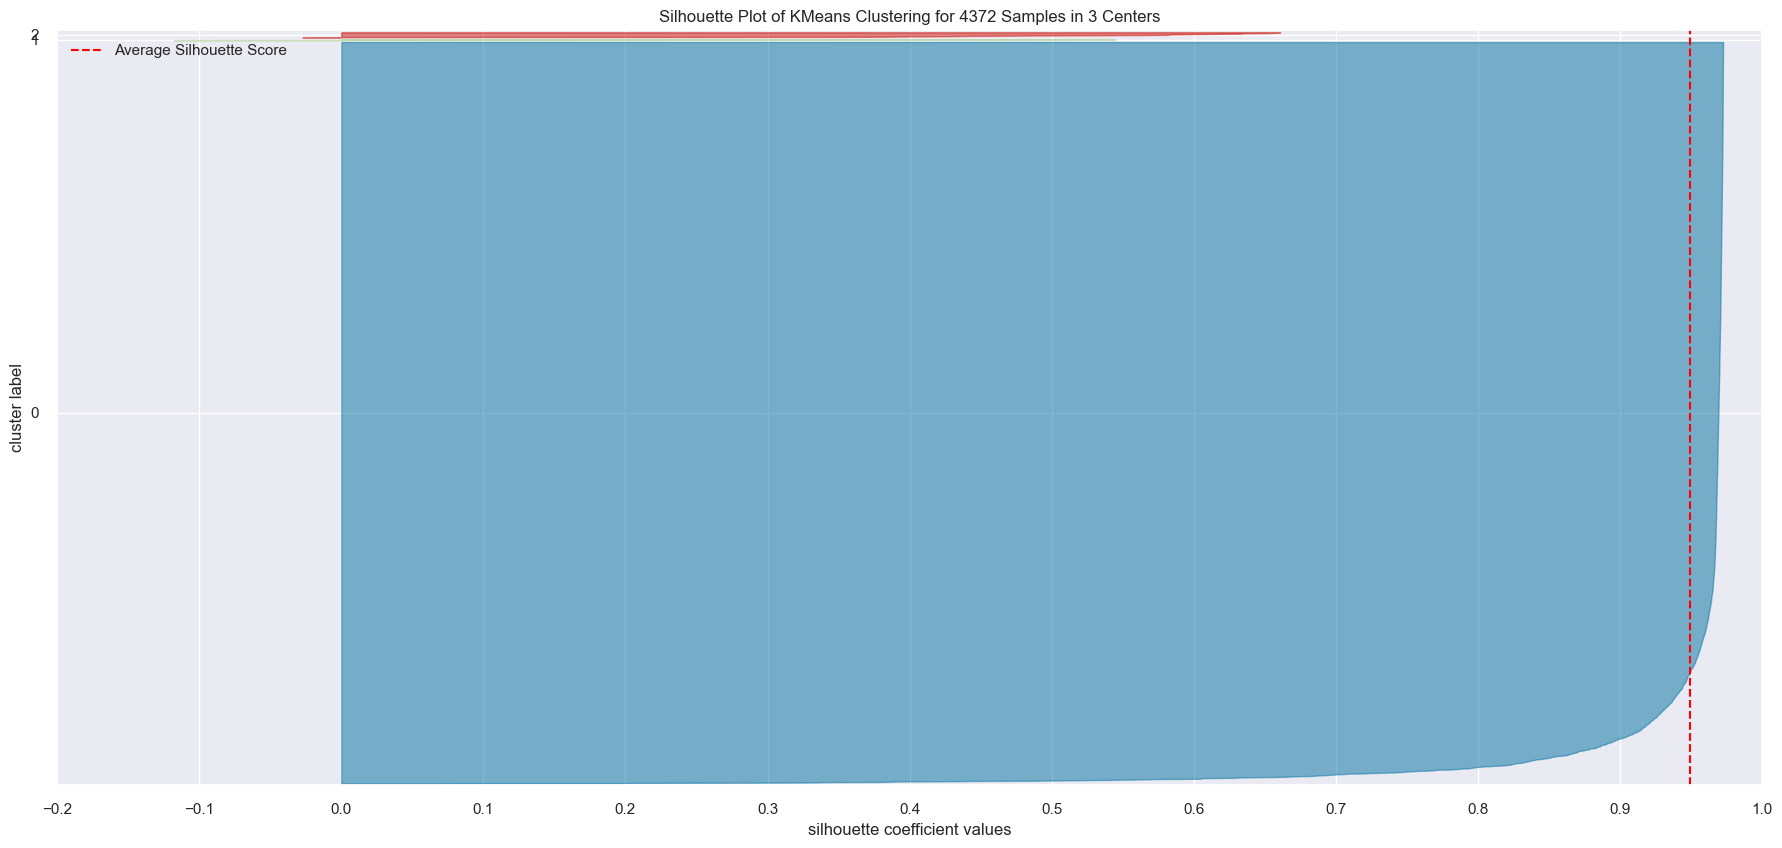

In [45]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.2 2D Plot

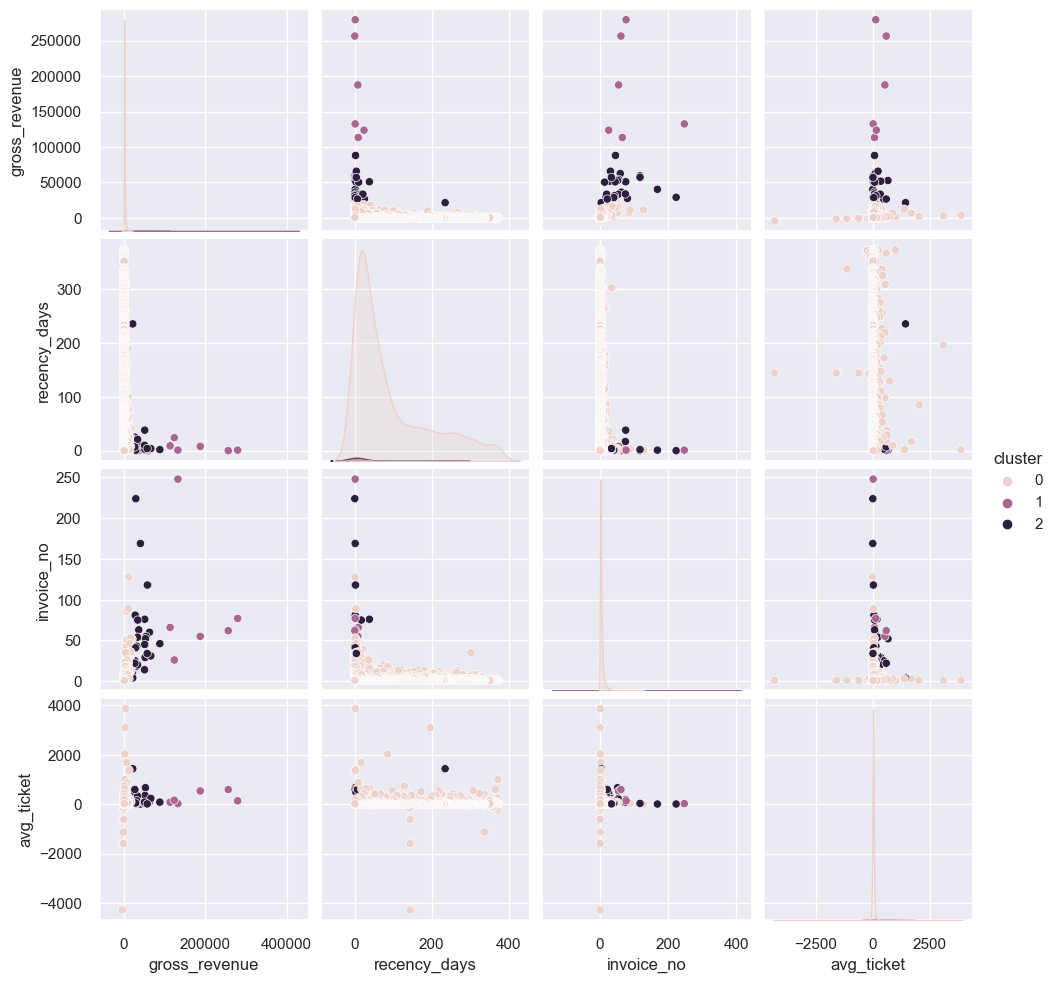

In [46]:
df_vis = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_vis, hue='cluster');

## 9.3 UMAP

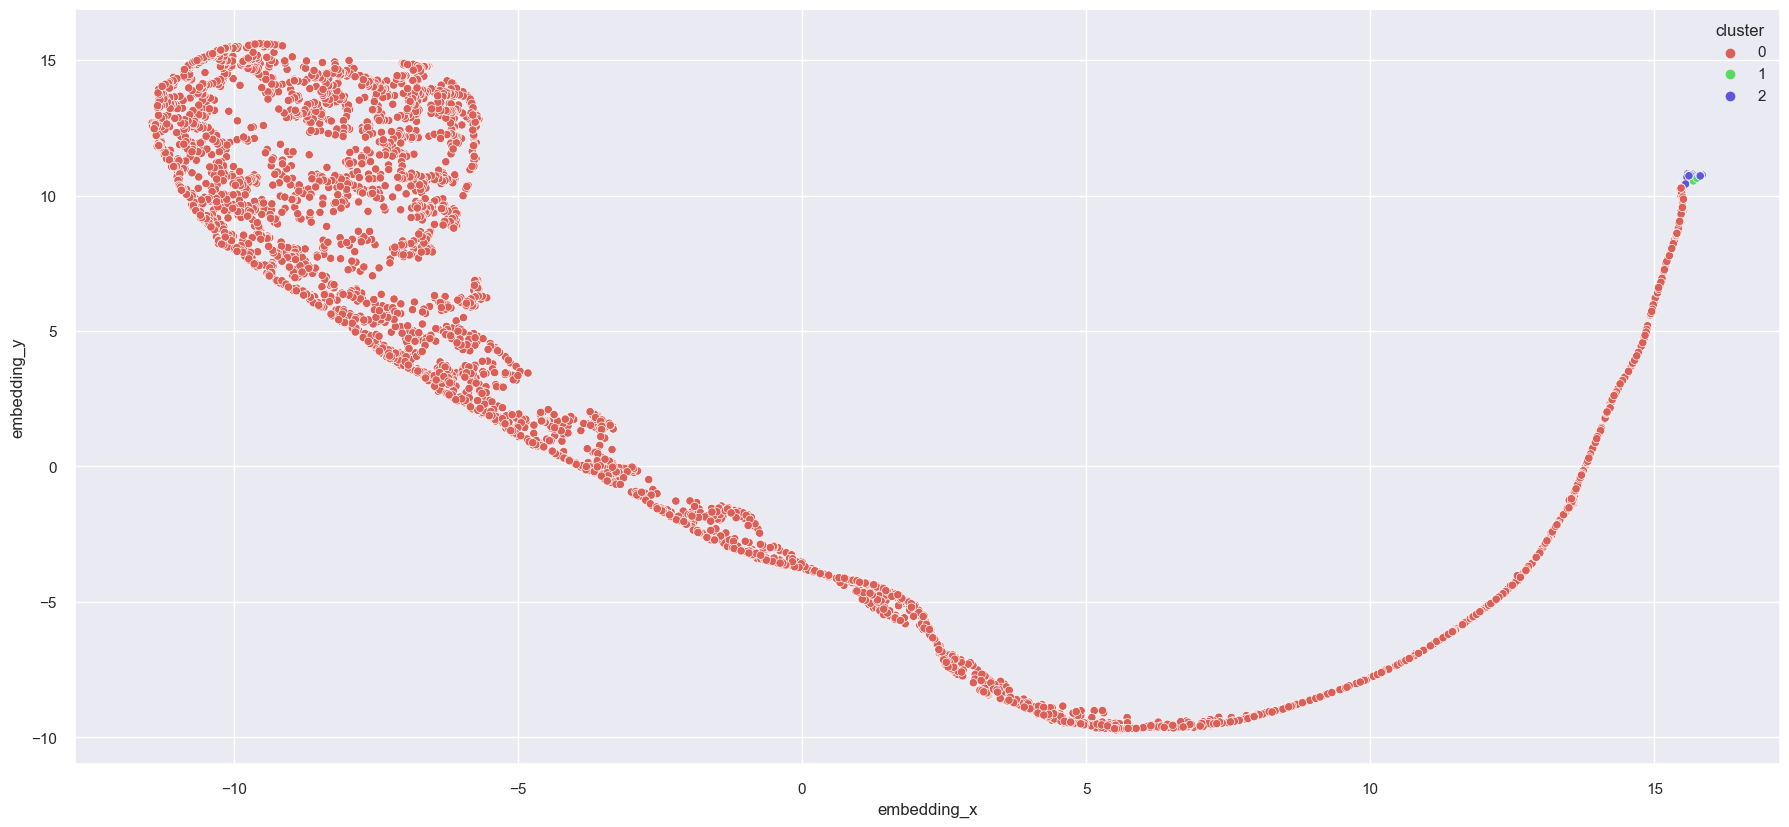

In [49]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_vis['embedding_x'] = embedding[:,0]
df_vis['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_vis['cluster'].unique())), data=df_vis);

## 9.4 Cluster Profile

In [50]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4335,99.154,1372.578,92.258,4.615,27.290
1,1,6,0.137,182181.982,7.167,89.000,253.626
2,2,31,0.709,40543.518,13.290,53.290,201.894


**Cluster 0:**

- Número de customer: 4.335 (99,15% dos customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: € 1.372,58
- Ticket médio: € 27,29

**Cluster 1: (Candidato a Insider)**

- Número de customer: 6 (0,14% dos customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: € 182.181,98
- Ticket médio: € 253,62

**Cluster 2:**

- Número de customer: 31 (0,71% dos customers)
- Recência em média: 13 dias
- Compras em média: 53 compras
- Receita em média: € 40.543,51
- Ticket médio: € 201,89

# 10.0 Deploy model to production